# AQI Data Analysis and Model testing

 This notebook contains a reproducible EDA pipeline for the city_day.csv Air Quality dataset for the regression task (predicting AQI). 
 
 The follwoing will be covered throughout this notebook: loading data, column overview, missingness, visualisations, basic baseline models. Any outputs will be saved in the correct folders for use in the report.

In [ ]:
#imports and file directory config
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cwd = Path.cwd()
print("Current working directory:", cwd)

if cwd.name.lower() == 'raw':
    project_root = cwd.parents[1]
else:
    project_root = cwd

print("Project root set to:", project_root)

# Define folders
DATA_RAW = project_root / "Data" / "Raw"
DATA_PROCESSED = project_root / "Data" / "Processed"
FIGURES = project_root / "Figures"
REPORTS = project_root / "Reports"
NOTEBOOKS = project_root / "Notebooks"

for p in [DATA_RAW, DATA_PROCESSED, FIGURES, REPORTS, NOTEBOOKS]:
    p.mkdir(parents=True, exist_ok=True)

print("Folders ensured:")
print("DATA_RAW:", DATA_RAW)
print("DATA_PROCESSED:", DATA_PROCESSED)
print("FIGURES:", FIGURES)
print("REPORTS:", REPORTS)
print("NOTEBOOKS:", NOTEBOOKS)

# Set matplotlib style defaults for readability
plt.rcParams['figure.dpi'] = 120
sns.set(style='whitegrid')

Current working directory: c:\Users\duplo\OneDrive - University of Keele\Desktop\MSc Data Science\Module 7\Assignment 2
Project root set to: c:\Users\duplo\OneDrive - University of Keele\Desktop\MSc Data Science\Module 7\Assignment 2
Folders ensured:
DATA_RAW: c:\Users\duplo\OneDrive - University of Keele\Desktop\MSc Data Science\Module 7\Assignment 2\Data\Raw
DATA_PROCESSED: c:\Users\duplo\OneDrive - University of Keele\Desktop\MSc Data Science\Module 7\Assignment 2\Data\Processed
FIGURES: c:\Users\duplo\OneDrive - University of Keele\Desktop\MSc Data Science\Module 7\Assignment 2\Figures
REPORTS: c:\Users\duplo\OneDrive - University of Keele\Desktop\MSc Data Science\Module 7\Assignment 2\Reports
NOTEBOOKS: c:\Users\duplo\OneDrive - University of Keele\Desktop\MSc Data Science\Module 7\Assignment 2\Notebooks


In [ ]:
# First step: Loading the data
csv_path = DATA_RAW / "city_day.csv"
if not csv_path.exists():
    raise FileNotFoundError(f"Expected dataset at {csv_path} - please place city_day.csv in this path.")

df = pd.read_csv(csv_path)
print('Loaded dataframe shape:', df.shape)
df.head()

Loaded dataframe shape: (29531, 16)


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
# Ensure report directory exists
(REPORTS).mkdir(parents=True, exist_ok=True)

# Check data shape and columns
shape_str = f"Shape: {df.shape}"
cols_str = ", ".join(df.columns.astype(str).tolist())

with open(REPORTS / "eda_summary.txt", "w", encoding="utf-8") as f:
    f.write("=== EDA Summary ===\n\n")
    f.write(shape_str + "\n\n")
    f.write("Columns:\n")
    f.write(cols_str + "\n\n")
    f.write("Head (first 5 rows):\n")
    f.write(df.head().to_string() + "\n\n")
    f.write("Tail (last 5 rows):\n")
    f.write(df.tail().to_string() + "\n")

#save head/tail as CSVs for appendices
df.head().to_csv(REPORTS / "head_sample.csv", index=False)
df.tail().to_csv(REPORTS / "tail_sample.csv", index=False)

shape_str, cols_str

('Shape: (29531, 16)',
 'City, Date, PM2.5, PM10, NO, NO2, NOx, NH3, CO, SO2, O3, Benzene, Toluene, Xylene, AQI, AQI_Bucket')

In [ ]:
# Second Step: Check Column types, missing values and unique counts
col_overview = pd.DataFrame({
    'dtype': df.dtypes.astype(str),
    'n_missing': df.isna().sum(),
    'pct_missing': df.isna().mean() * 100,
    'n_unique': df.nunique(dropna=False)
})
col_overview = col_overview.reset_index().rename(columns={'index':'column'})
col_overview.to_csv(REPORTS / "column_overview.csv", index=False)
col_overview

,column,dtype,n_missing,pct_missing,n_unique
0,City,object,0,0.000000,26
1,Date,object,0,0.000000,2009
2,PM2.5,float64,4598,15.570079,11717
3,PM10,float64,11140,37.723071,12572
4,NO,float64,3582,12.129626,5777
5,NO2,float64,3585,12.139785,7405
6,NOx,float64,4185,14.171549,8157
7,NH3,float64,10328,34.973418,5923
8,CO,float64,2059,6.972334,1780
9,SO2,float64,3854,13.050692,4762


In [ ]:
# Third step: Parse Date column and basic cleaning
date_col = None
for candidate in ['Date', 'date', 'DATE']:
    if candidate in df.columns:
        date_col = candidate
        break

if date_col is None:
    print("No date column found.")
else:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    print(f"Converted {date_col} to datetime. Null datetimes:", df[date_col].isna().sum())

Converted Date to datetime. Null datetimes: 0


In [ ]:
# Fourth Step: Checking of descriptive statistics for numeric columns
num_stats = df.describe().T
num_stats['skew'] = df.select_dtypes(include='number').skew(numeric_only=True)
num_stats['kurtosis'] = df.select_dtypes(include='number').kurtosis(numeric_only=True)
num_stats.to_csv(REPORTS / "descriptive_stats.csv")
num_stats

,count,mean,min,25%,50%,75%,max,std,skew,kurtosis
Date,29531,2018-05-14 05:40:15.807118080,2015-01-01 00:00:00,2017-04-16 00:00:00,2018-08-05 00:00:00,2019-09-03 00:00:00,2020-07-01 00:00:00,NaN,NaN,NaN
PM2.5,24933.0,67.450578,0.04,28.82,48.57,80.59,949.99,64.661449,3.369960,21.132222
PM10,18391.0,118.127103,0.01,56.255,95.68,149.745,1000.0,90.60511,2.053189,6.747873
NO,25949.0,17.57473,0.02,5.63,9.89,19.95,390.68,22.785846,3.883166,25.164347
NO2,25946.0,28.560659,0.01,11.75,21.69,37.62,362.21,24.474746,2.464560,11.211125
NOx,25346.0,32.309123,0.0,12.82,23.52,40.1275,467.63,31.646011,2.569915,10.836335
NH3,19203.0,23.483476,0.01,8.58,15.85,30.02,352.89,25.684275,4.083993,27.964608
CO,27472.0,2.248598,0.0,0.51,0.89,1.45,175.81,6.962884,8.878322,109.488050
SO2,25677.0,14.531977,0.01,5.67,9.16,15.22,193.86,18.133775,4.083660,22.067101
O3,25509.0,34.49143,0.01,18.86,30.84,45.57,257.73,21.694928,1.330119,3.429465


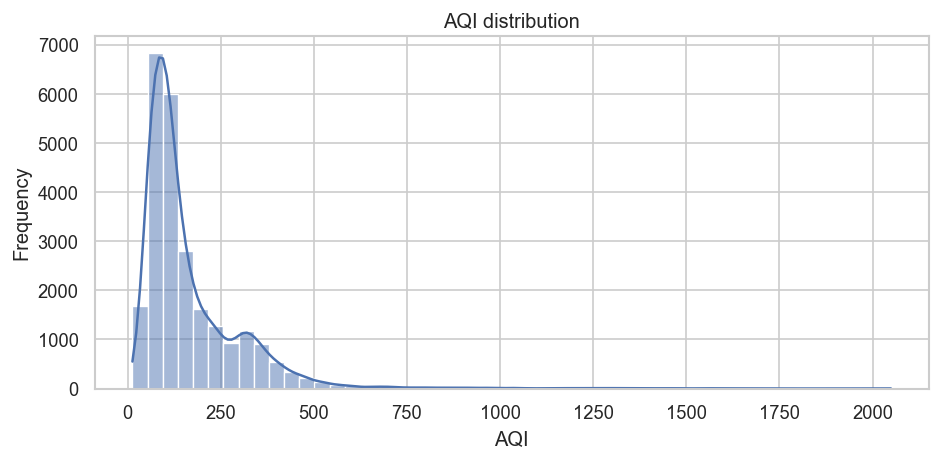

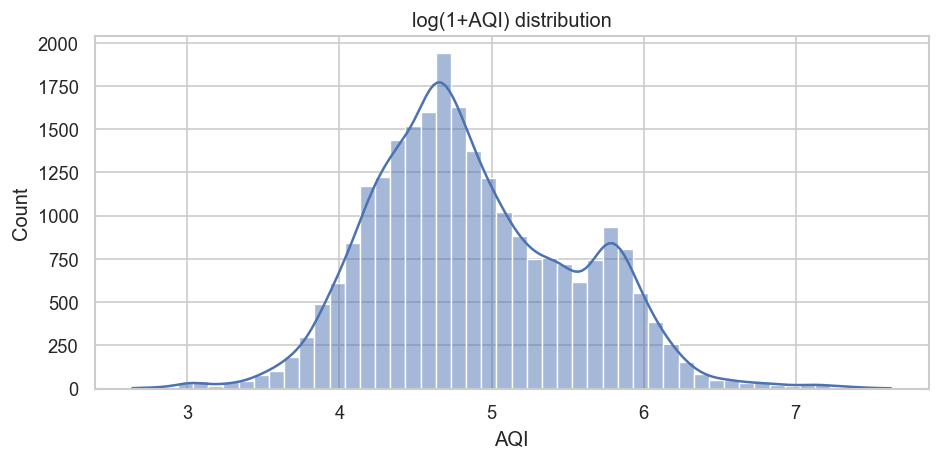

In [ ]:
# Fifth Step: AQI distribution using a histogram + log transformation
if 'AQI' not in df.columns:
    print("AQI column not found.")
else:
    plt.figure(figsize=(8,4))
    sns.histplot(df['AQI'].dropna(), bins=50, kde=True)
    plt.title("AQI distribution")
    plt.xlabel("AQI")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(FIGURES / "aqi_distribution.png")
    plt.show()

    # log1p
    plt.figure(figsize=(8,4))
    sns.histplot(np.log1p(df['AQI'].dropna()), bins=50, kde=True)
    plt.title("log(1+AQI) distribution")
    plt.tight_layout()
    plt.savefig(FIGURES / "aqi_log1p_distribution.png")
    plt.show()

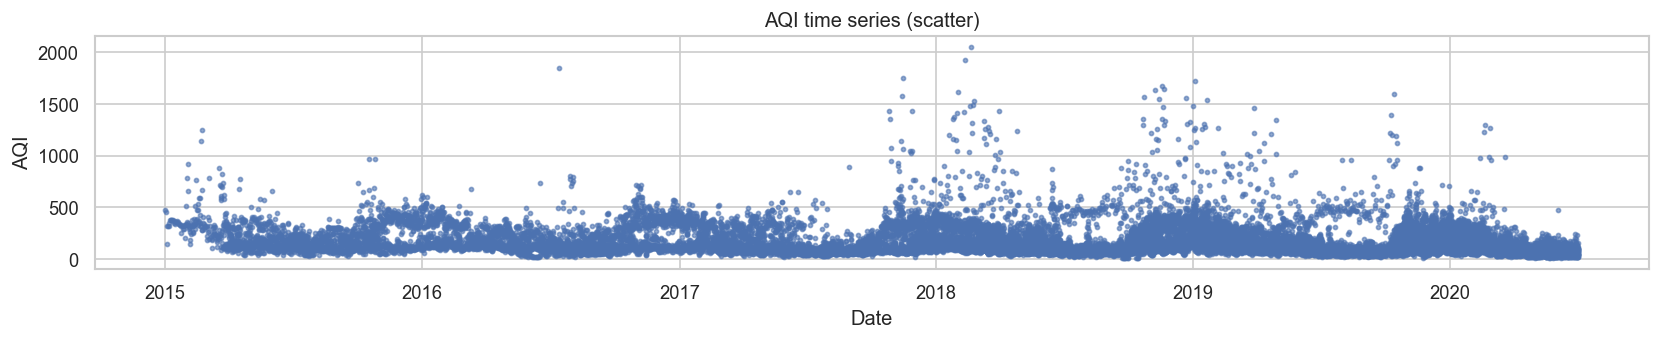

C:\Users\duplo\AppData\Local\Temp\ipykernel_68360\1618341277.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index('Date').resample('M')['AQI'].mean()


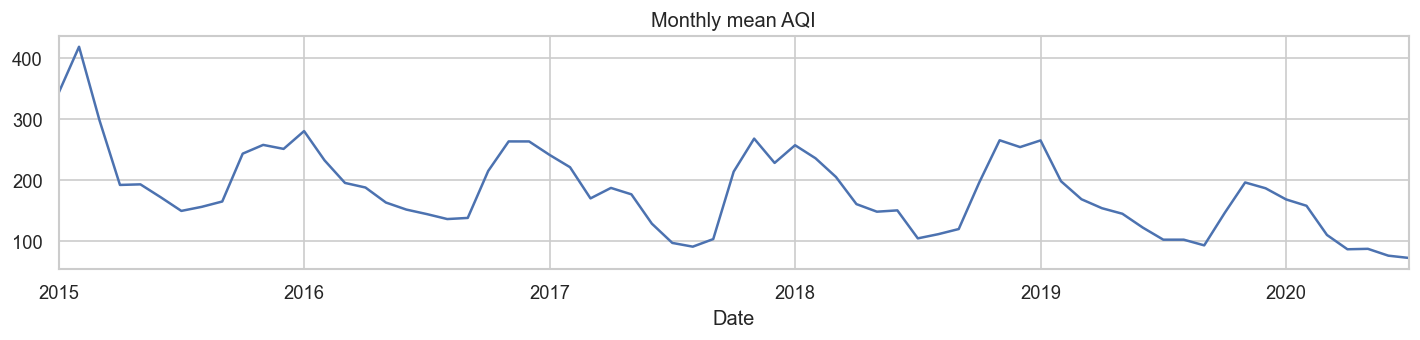

In [ ]:
# Sixth Step: Time series scatter plot of AQI and monthly averages
if 'Date' in df.columns and 'AQI' in df.columns:
    df_sorted = df.sort_values('Date')
    plt.figure(figsize=(14,3))
    plt.scatter(df_sorted['Date'], df_sorted['AQI'], s=6, alpha=0.6)
    plt.title("AQI time series (scatter)")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.tight_layout()
    plt.savefig(FIGURES / "aqi_timeseries_scatter.png")
    plt.show()

    # monthly averages
    monthly = df.set_index('Date').resample('M')['AQI'].mean()
    plt.figure(figsize=(12,3))
    monthly.plot()
    plt.title("Monthly mean AQI")
    plt.tight_layout()
    plt.savefig(FIGURES / "aqi_monthly_mean.png")
    plt.show()
else:
    print("Date or AQI column missing; cannot plot time series.")

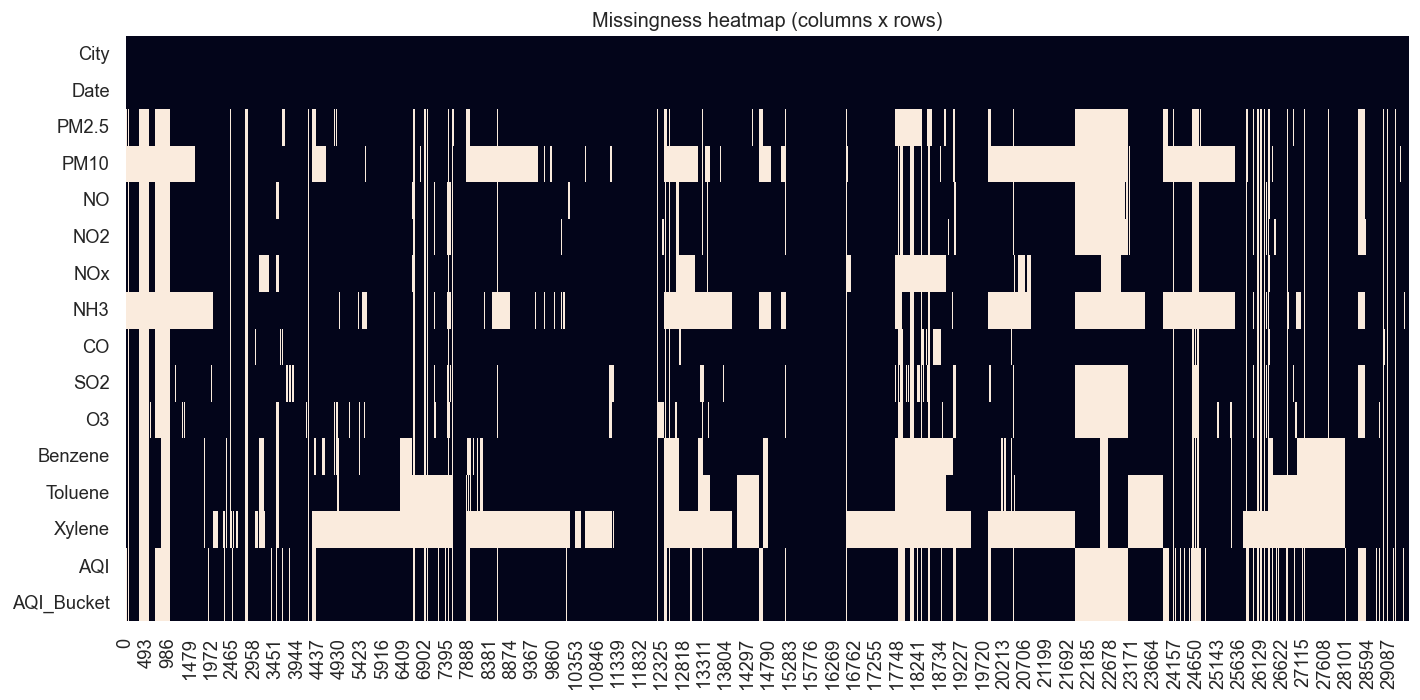

C:\Users\duplo\AppData\Local\Temp\ipykernel_68360\38097549.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_date = df.groupby('Date').apply(lambda x: x.isnull().mean().mean())


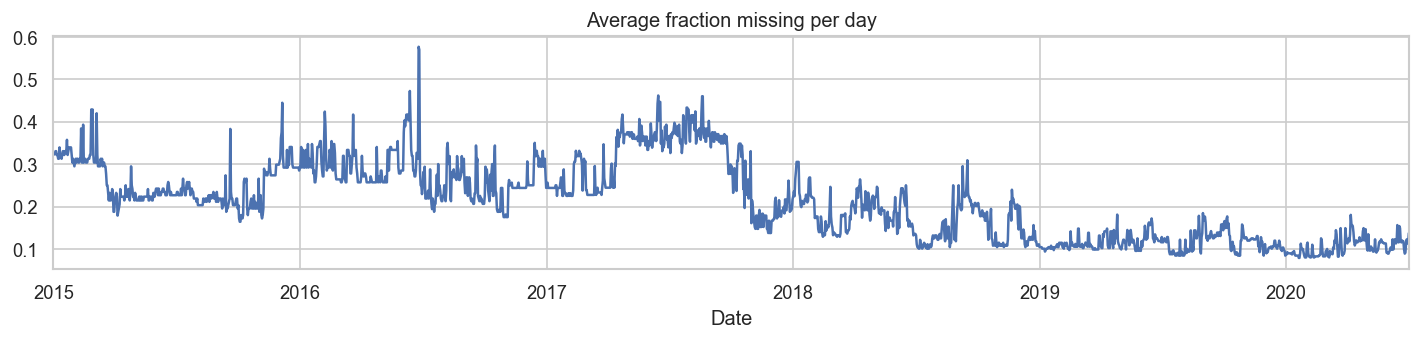

In [ ]:
# Seventh Step: Checking Missingness with heatmap and missingness over time
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull().T, cbar=False)
plt.title("Missingness heatmap (columns x rows)")
plt.tight_layout()
plt.savefig(FIGURES / "missingness_heatmap.png")
plt.show()

if 'Date' in df.columns:
    missing_by_date = df.groupby('Date').apply(lambda x: x.isnull().mean().mean())
    plt.figure(figsize=(12,3))
    missing_by_date.plot()
    plt.title("Average fraction missing per day")
    plt.tight_layout()
    plt.savefig(FIGURES / "missing_by_date.png")
    plt.show()


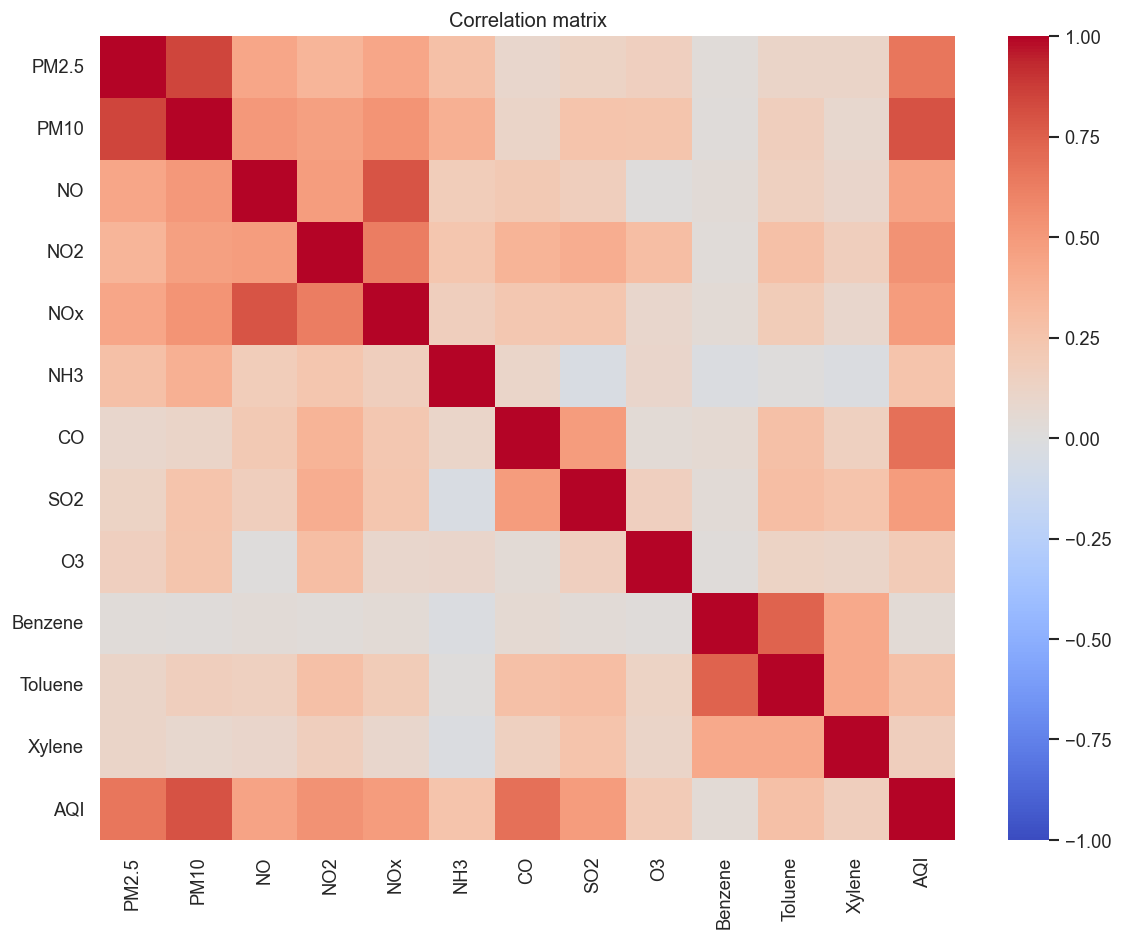

In [ ]:
# Step 8: Checking which pollutants have a greater effect on AQI with a correlation matrix and correlation with AQI
numeric = df.select_dtypes(include=['number']).copy()
corr = numeric.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.tight_layout()
plt.savefig(FIGURES / "correlation_matrix.png")
plt.show()

if 'AQI' in numeric.columns:
    corr_with_aqi = corr['AQI'].sort_values(ascending=False)
    corr_with_aqi.to_csv(REPORTS / "corr_with_aqi.csv")
    corr_with_aqi

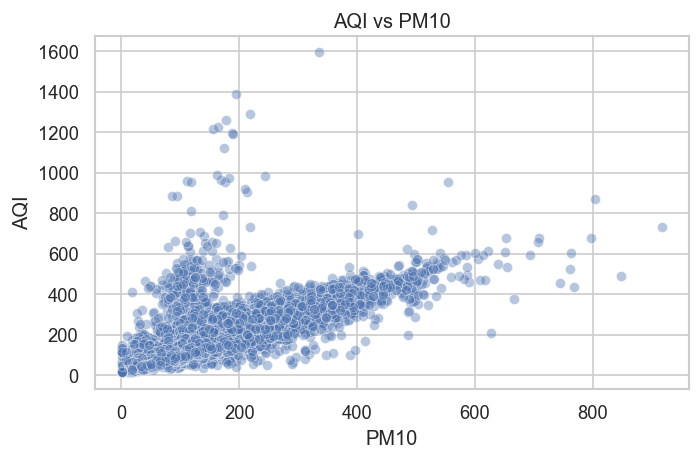

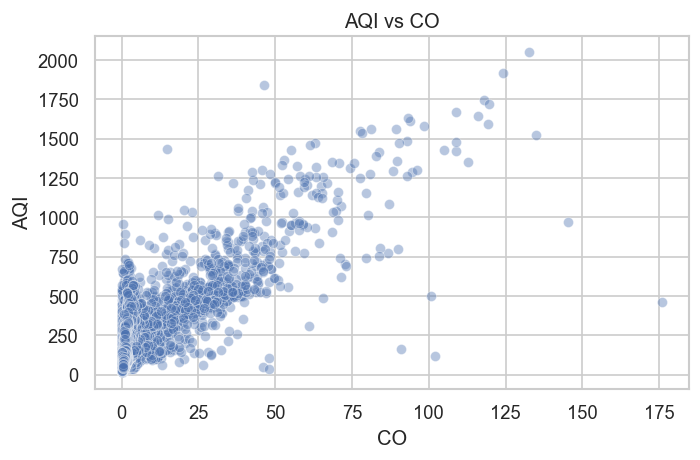

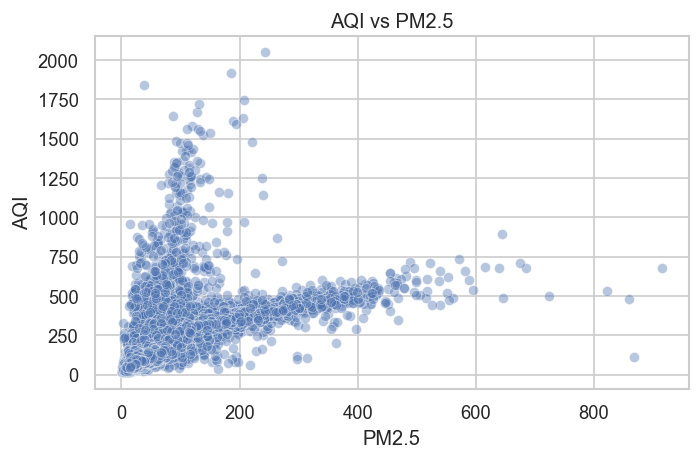

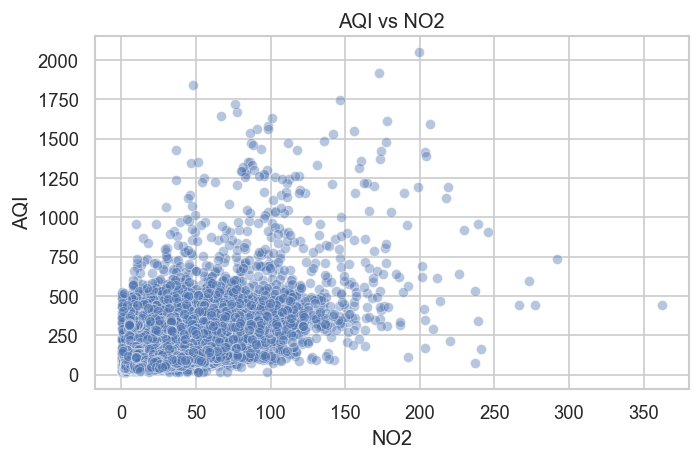

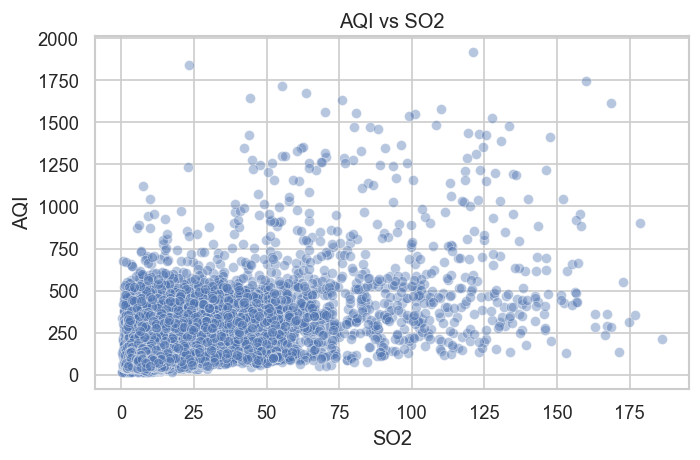

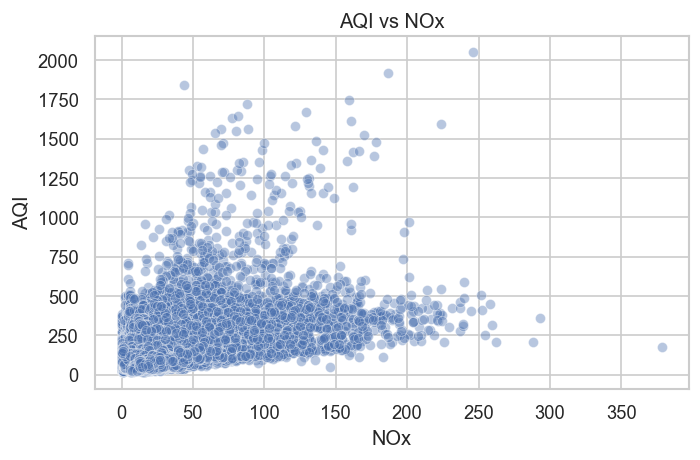

In [ ]:
# Nineth Step: Using the correlation matrix to create scatterplots of the top predictors vs AQI
if 'AQI' in numeric.columns:
    corr_with_aqi = corr['AQI'].sort_values(ascending=False)
    top_feats = corr_with_aqi.index.drop('AQI').tolist()[:6]
    for feat in top_feats:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df[feat], y=df['AQI'], alpha=0.4)
        plt.title(f"AQI vs {feat}")
        plt.tight_layout()
        fname = f"aqi_vs_{feat}.png".replace("/", "_")
        plt.savefig(FIGURES / fname)
        plt.show()
else:
    print("AQI or numeric columns missing.")

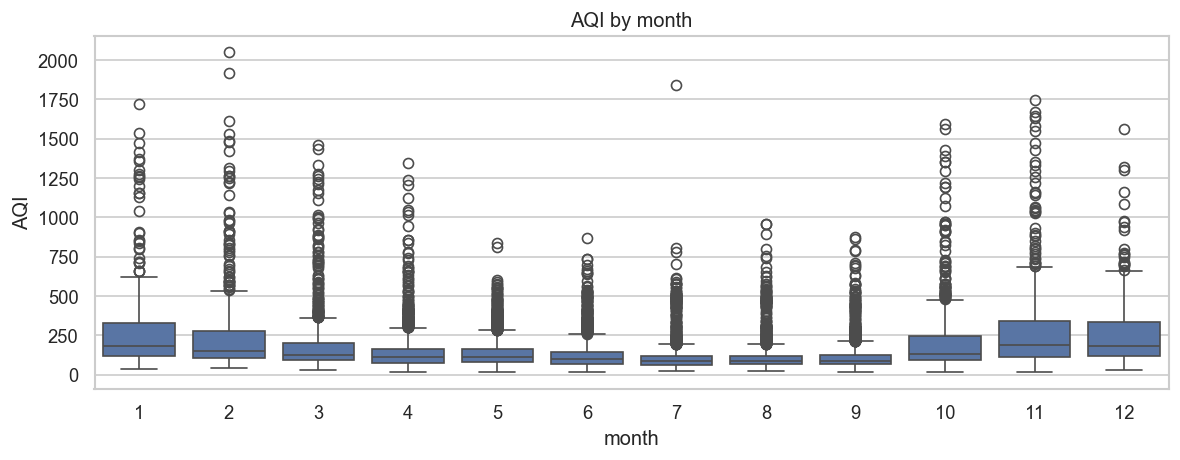

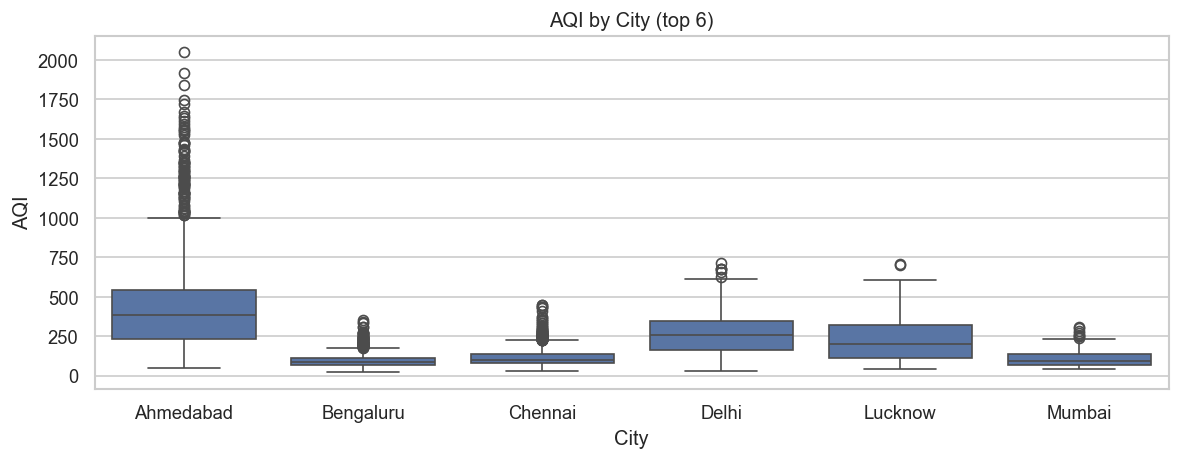

In [ ]:
# Tenth Step: Boxplots by month and by city (using only the top 6 cities)
if 'Date' in df.columns:
    df['month'] = df['Date'].dt.month
    plt.figure(figsize=(10,4))
    sns.boxplot(x='month', y='AQI', data=df)
    plt.title("AQI by month")
    plt.tight_layout()
    plt.savefig(FIGURES / "aqi_by_month.png")
    plt.show()
else:
    print("Date not available for month boxplot.")

if 'City' in df.columns:
    top_cities = df['City'].value_counts().index[:6]
    subset = df[df['City'].isin(top_cities)]
    plt.figure(figsize=(10,4))
    sns.boxplot(x='City', y='AQI', data=subset)
    plt.title("AQI by City (top 6)")
    plt.tight_layout()
    plt.savefig(FIGURES / "aqi_by_top6cities.png")
    plt.show()
else:
    print("City column not available.")

In [ ]:
# Eleventh Step: Detecting outliers for AQI using interquartile range
if 'AQI' in df.columns:
    q1 = df['AQI'].quantile(0.25)
    q3 = df['AQI'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df['AQI'] < lower) | (df['AQI'] > upper)]
    print("AQI outlier count:", outliers.shape[0])
    outliers.head().to_csv(REPORTS / "aqi_outliers_sample.csv", index=False)
else:
    print("AQI column missing; cannot compute outliers.")

AQI outlier count: 1358


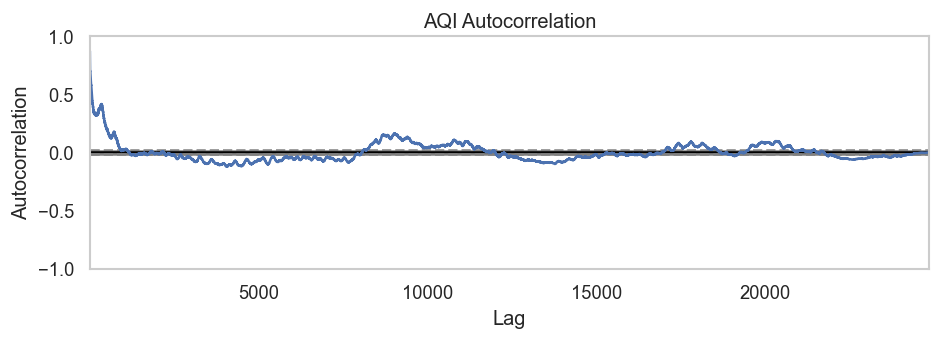

In [ ]:
# Twelth Step: Autocorrelation plot for AQI
from pandas.plotting import autocorrelation_plot
if 'Date' in df.columns and 'AQI' in df.columns:
    series = df.set_index('Date')['AQI'].dropna()
    plt.figure(figsize=(8,3))
    autocorrelation_plot(series)
    plt.title("AQI Autocorrelation")
    plt.tight_layout()
    plt.savefig(FIGURES / "aqi_autocorr.png")
    plt.show()
else:
    print("Date or AQI missing; skip autocorrelation.")

### Feature engineering using EDA results

Based on the results of our EDA above, I decided to create features such as:

- month, day_of_week, is_weekend
- Lag features: aqi_lag1 (AQI the day prior), aqi_lag7 (AQI 7 days prior)
- Rolling means: aqi_roll7 (7 day rolling average)
- Interaction terms and log transforms for skewed predictors

In [ ]:
# lag and rolling features
# First we ensure that the data is sorted by City and Date
if 'Date' in df.columns:
    df = df.sort_values(['City', 'Date']) if 'City' in df.columns else df.sort_values('Date')

    # create lag features
    if 'City' in df.columns:
        df['aqi_lag1'] = df.groupby('City')['AQI'].shift(1)
        df['aqi_lag7'] = df.groupby('City')['AQI'].shift(7)
        df['aqi_roll7'] = df.groupby('City')['AQI'].transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).mean())
    else:
        df['aqi_lag1'] = df['AQI'].shift(1)
        df['aqi_lag7'] = df['AQI'].shift(7)
        df['aqi_roll7'] = df['AQI'].shift(1).rolling(window=7, min_periods=1).mean()

    # save to reports folder
    sample = df[['City', 'Date', 'AQI', 'aqi_lag1', 'aqi_lag7', 'aqi_roll7']].head(10)
    sample.to_csv(REPORTS / "lag_feature_sample.csv", index=False)
    display(sample)


,City,Date,AQI,aqi_lag1,aqi_lag7,aqi_roll7
0,Ahmedabad,2015-01-01,NaN,NaN,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,NaN,NaN
5,Ahmedabad,2015-01-06,NaN,NaN,NaN,NaN
6,Ahmedabad,2015-01-07,NaN,NaN,NaN,NaN
7,Ahmedabad,2015-01-08,NaN,NaN,NaN,NaN
8,Ahmedabad,2015-01-09,NaN,NaN,NaN,NaN
9,Ahmedabad,2015-01-10,NaN,NaN,NaN,NaN


In [ ]:
# create a quick baseline model (using dummy mean predictor and Linear Regression)
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare a simple numeric feature set
df_model = df.dropna(subset=['AQI']).copy()
X = df_model.select_dtypes(include=['number']).drop(columns=['AQI'], errors='ignore').fillna(0)
y = df_model['AQI'].values

if len(X) < 2:
    print("Not enough numeric features for baseline.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    dummy = DummyRegressor(strategy='mean')
    dummy.fit(X_train, y_train)
    y_pred_dummy = dummy.predict(X_test)
    rmse_dummy = mean_squared_error(y_test, y_pred_dummy, squared=False)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)

    results = pd.DataFrame({
        'model': ['DummyMean','LinearRegression'],
        'rmse': [rmse_dummy, rmse_lr]
    })
    results.to_csv(REPORTS / "baseline_results.csv", index=False)
    results

c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Save a cleaned sample (dropping rows with missing target AQI)
# Keep only rows with AQI not null and basic fills for numeric missing values
df_clean = df.dropna(subset=['AQI']).copy()
num_cols = df_clean.select_dtypes(include=['number']).columns.tolist()
# simple fill with median for demonstration
for c in num_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())

df_clean.to_csv(DATA_PROCESSED / "aqi_clean_sample.csv", index=False)
print("Saved cleaned sample to:", DATA_PROCESSED / "aqi_clean_sample.csv")

Saved cleaned sample to: c:\Users\duplo\OneDrive - University of Keele\Desktop\MSc Data Science\Module 7\Assignment 2\Data\Processed\aqi_clean_sample.csv


In [ ]:
# Train/Test Split & Scaling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features (not including AQI and non-numeric columns)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('AQI')
X = df[numeric_cols].fillna(df[numeric_cols].mean())  # handle missing with mean
y = df['AQI'].fillna(df['AQI'].mean())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Create a baseline model — Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
lr_rmse = mean_squared_error(y_test, y_pred_lr, squared=False)
lr_r2 = r2_score(y_test, y_pred_lr)
lr_mae = mean_absolute_error(y_test, y_pred_lr)

print(f"Linear Regression — RMSE: {lr_rmse:.2f}, R²: {lr_r2:.3f}")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))


Linear Regression — RMSE: 45.77, R²: 0.861
MAE: 23.337048491438843


c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Create Random Forest Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

rf = RandomForestRegressor(random_state=42, n_estimators=200)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest — RMSE: {rf_rmse:.2f}, R²: {rf_r2:.3f}")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))


Random Forest — RMSE: 38.80, R²: 0.900
MAE: 17.490855860744308


c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Install xgboost
!pip install xgboost


   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 217.9 kB/s eta 0:04:21
   ---------------------------------------- 0.0/56.8 MB 217.9 kB/s eta 0:04:21
   ---------------------------------------- 0.0/56.8 MB 245.8 kB/s eta 0:03:52
   ---------------------------------------- 0.1/56.8 MB 492.8 kB/s eta 0:01:56
   ---------------------------------------- 0.3/56.8 MB 1.1 MB/s eta 0:00:52
   ---------------------------------------- 0.4/56.8 MB 1.4 MB/s eta 0:00:41
    --------------------------------------- 0.7/56.8 MB 2.1 MB/s eta 0:00:28
    --------------------------------------- 0.8/56.8 MB 2.3 MB/s eta 0:00:25
   - -------------------------------------- 1.5/56.8 MB 3.4 MB/s eta 0:00:17
   - -------------------------------------- 2.2/56.8 MB 4.4 MB/s eta 0:00:13
   - -------------------------------------- 2.3/56.8 MB 4.2 MB/s eta 0:00:14
   --

In [ ]:
import xgboost
print(xgboost.__version__)


3.0.5


In [ ]:
# Create XGBoost Model
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
xgb_r2 = r2_score(y_test, y_pred_xgb)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost — RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.3f}")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))


XGBoost — RMSE: 38.89, R²: 0.900
MAE: 17.88103492087115


c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Hyperparameter tuning for RandomForest
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=10, scoring='neg_root_mean_squared_error',
    cv=3, random_state=42, n_jobs=-1, verbose=1
)
rf_random.fit(X_train, y_train)

best_rf = rf_random.best_estimator_
print("Best RF Parameters:", rf_random.best_params_)

# Evaluate the tuned RandomForest model
y_pred_rf_best = best_rf.predict(X_test)
rf_best_rmse = mean_squared_error(y_test, y_pred_rf_best, squared=False)
rf_best_r2 = r2_score(y_test, y_pred_rf_best)
rf_best_mae = mean_absolute_error(y_test, y_pred_rf_best)
print(f"Tuned Random Forest — RMSE: {rf_best_rmse:.2f}, R²: {rf_best_r2:.3f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best RF Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 15}
Tuned Random Forest — RMSE: 38.19, R²: 0.903


c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
#Train and evaluate multiple neural network configurations

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

mlp_results = []

# Define multiple configurations
hidden_layer_options = [(50,), (100,), (100, 50), (50, 50)]
learning_rate_options = [0.001, 0.01, 0.05]

for hl in hidden_layer_options:
    for lr in learning_rate_options:
        mlp = MLPRegressor(hidden_layer_sizes=hl, 
                           learning_rate_init=lr,
                           max_iter=1000,
                           random_state=42)
        mlp.fit(X_train_scaled, y_train)
        y_pred = mlp.predict(X_test_scaled)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        mlp_results.append({
            'Model': 'Neural Network',
            'hidden_layers': hl,
            'learning_rate': lr,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

mlp_results_df = pd.DataFrame(mlp_results)
display(mlp_results_df.sort_values(by='RMSE'))

# Save best model
best_mlp_row = mlp_results_df.loc[mlp_results_df['RMSE'].idxmin()]
best_hl = best_mlp_row['hidden_layers']
best_lr = best_mlp_row['learning_rate']

mlp_best = MLPRegressor(hidden_layer_sizes=best_hl, 
                        learning_rate_init=best_lr, 
                        max_iter=1000, 
                        random_state=42)
mlp_best.fit(X_train_scaled, y_train)
y_pred_mlp_best = mlp_best.predict(X_test_scaled)

mlp_best_rmse = best_mlp_row['RMSE']
mlp_best_mae = best_mlp_row['MAE']
mlp_best_r2 = best_mlp_row['R2']


,Model,hidden_layers,learning_rate,RMSE,MAE,R2
3,Neural Network,"(100,)",0.001,39.363695,19.658450,0.897218
6,Neural Network,"(100, 50)",0.001,39.367712,19.190313,0.897197
9,Neural Network,"(50, 50)",0.001,39.566546,19.374624,0.896156
0,Neural Network,"(50,)",0.001,39.898154,20.332488,0.894408
5,Neural Network,"(100,)",0.050,40.094448,20.402514,0.893366
1,Neural Network,"(50,)",0.010,40.196096,20.480833,0.892825
4,Neural Network,"(100,)",0.010,40.369062,20.224280,0.891900
2,Neural Network,"(50,)",0.050,41.060509,21.062628,0.888166
11,Neural Network,"(50, 50)",0.050,41.447484,20.877520,0.886048
8,Neural Network,"(100, 50)",0.050,44.053267,21.052409,0.871269


In [ ]:
# Model comparison
import pandas as pd
from sklearn.metrics import mean_absolute_error

# create a results DF
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Tuned RF', 'Neural Network'],
    'RMSE': [lr_rmse, rf_rmse, xgb_rmse, rf_best_rmse, mlp_best_rmse],
    'MAE': [lr_mae, rf_mae, xgb_mae, rf_best_mae, mlp_best_mae],
    'R2': [lr_r2, rf_r2, xgb_r2, rf_best_r2, mlp_best_r2]
})

# Sort by RMSE (Where lower is better)
results = results.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

def highlight_best(s, metric, higher_is_better=False):
    """
    Highlights the best value in a pandas Series.
    """
    best_val = s.max() if higher_is_better else s.min()
    return ['background-color: #d4edda; font-weight: bold;' if v == best_val else '' for v in s]


display(results.style.highlight_min(subset=['RMSE', 'MAE'], color='green')
                          .highlight_max(subset=['R2'], color='blue'))


results.to_csv(REPORTS / "model_comparison.csv", index=False)


,Model,RMSE,MAE,R2
0,Tuned RF,38.187838,17.377646,0.903266
1,Random Forest,38.804778,17.490856,0.900116
2,XGBoost,38.889846,17.881035,0.899677
3,Neural Network,39.363695,19.658450,0.897218
4,Linear Regression,45.774437,23.337048,0.861013


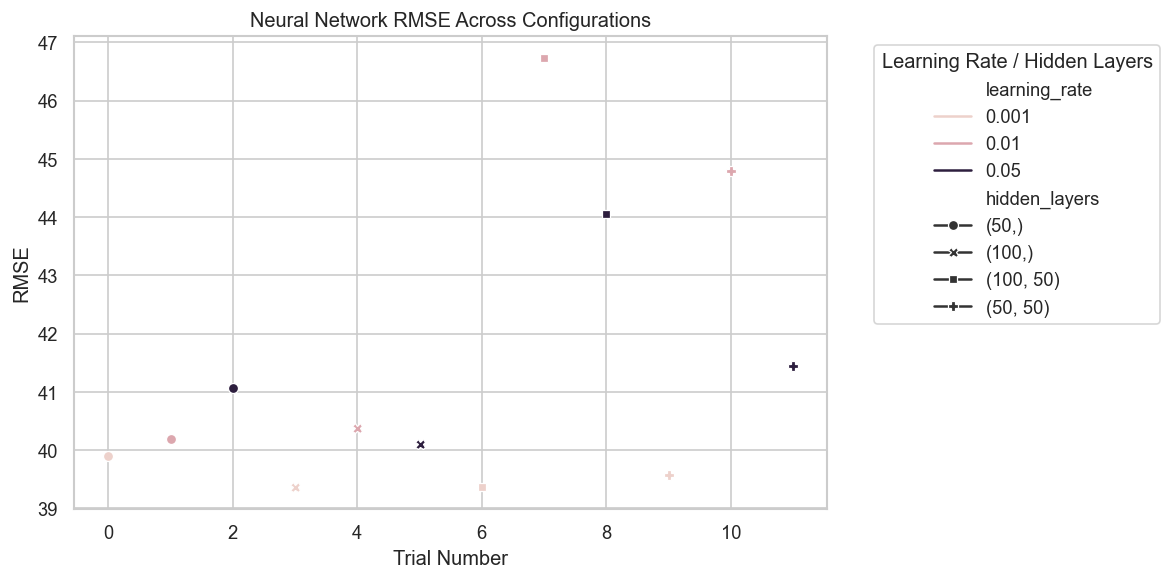

In [ ]:
# RMSE across Neural Network configurations
plt.figure(figsize=(10,5))
sns.lineplot(data=mlp_results_df, 
             x=mlp_results_df.index, 
             y='RMSE', 
             hue='learning_rate', 
             style='hidden_layers', 
             markers=True, dashes=False)
plt.title('Neural Network RMSE Across Configurations')
plt.xlabel('Trial Number')
plt.ylabel('RMSE')
plt.legend(title='Learning Rate / Hidden Layers', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(FIGURES / "Neural Network RMSE Across Configurations.png")
plt.show()


## Model Trials — Multiple Configurations

In this section of the notebook, I test multiple configurations for each model to evaluate how changes in hyperparameters affect their performance.  
We include Linear Regression, Random Forest, XGBoost, and a Neural Network (MLPRegressor).  

Metrics used:
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- R² (Coefficient of Determination)

This should help us assess model stability and identify optimal hyperparameters


In [ ]:
# Random Forest Trials

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf_trials = []
for n in [100, 200, 500]:
    for depth in [10, 20, None]:
        rf = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=42)
        rf.fit(X_train, y_train)
        preds = rf.predict(X_test)
        rmse = mean_squared_error(y_test, preds, squared=False)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        rf_trials.append({
            'Model': 'Random Forest',
            'n_estimators': n,
            'max_depth': depth,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

rf_results = pd.DataFrame(rf_trials)
display(rf_results.sort_values('RMSE'))


c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

,Model,n_estimators,max_depth,RMSE,MAE,R2
1,Random Forest,100,20.0,38.592465,17.565317,0.901206
0,Random Forest,100,10.0,38.625325,18.222582,0.901037
2,Random Forest,100,NaN,38.686416,17.549370,0.900724
7,Random Forest,500,20.0,38.780246,17.501988,0.900242
5,Random Forest,200,NaN,38.804778,17.490856,0.900116
8,Random Forest,500,NaN,38.813796,17.497703,0.900069
4,Random Forest,200,20.0,38.843669,17.526382,0.899915
3,Random Forest,200,10.0,38.943589,18.268541,0.899400
6,Random Forest,500,10.0,39.074250,18.283699,0.898724


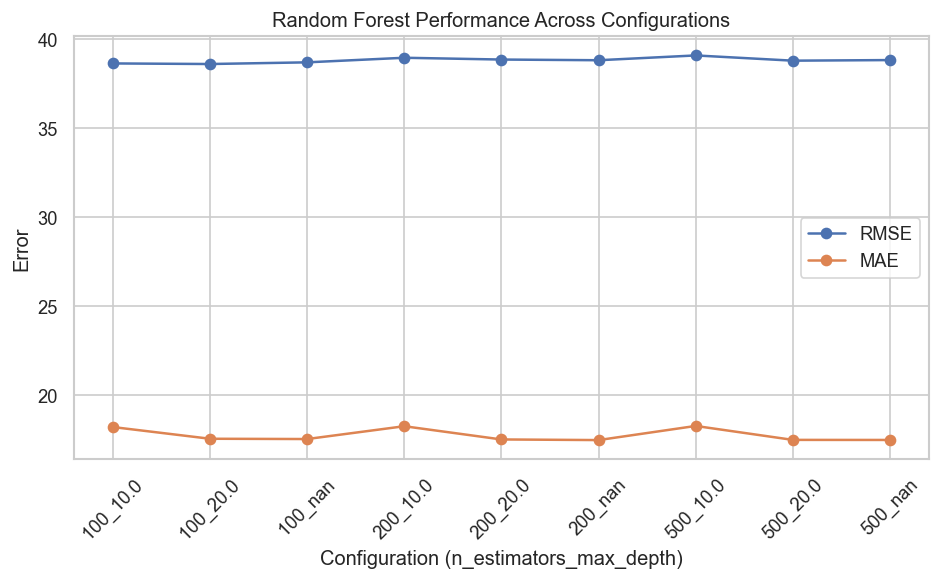

In [ ]:
# Random Forest Performance Visualised
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(rf_results['n_estimators'].astype(str) + '_' + rf_results['max_depth'].astype(str),
         rf_results['RMSE'], marker='o', label='RMSE')
plt.plot(rf_results['n_estimators'].astype(str) + '_' + rf_results['max_depth'].astype(str),
         rf_results['MAE'], marker='o', label='MAE')
plt.title("Random Forest Performance Across Configurations")
plt.xlabel("Configuration (n_estimators_max_depth)")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(REPORTS / "rf_config_comparison.png")
plt.show()


In [ ]:
# XGBoost Trials

xgb_trials = []
for lr in [0.01, 0.05, 0.1]:
    for n in [100, 300, 500]:
        xgb = XGBRegressor(
            n_estimators=n,
            learning_rate=lr,
            random_state=42,
            verbosity=0
        )
        xgb.fit(X_train, y_train)
        preds = xgb.predict(X_test)
        rmse = mean_squared_error(y_test, preds, squared=False)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        xgb_trials.append({
            'Model': 'XGBoost',
            'learning_rate': lr,
            'n_estimators': n,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

xgb_results = pd.DataFrame(xgb_trials)
display(xgb_results.sort_values('RMSE'))


c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

,Model,learning_rate,n_estimators,RMSE,MAE,R2
1,XGBoost,0.01,300,38.082303,19.064975,0.903800
2,XGBoost,0.01,500,38.389145,18.015347,0.902244
3,XGBoost,0.05,100,38.699808,18.153590,0.900655
6,XGBoost,0.10,100,38.846629,17.875132,0.899900
4,XGBoost,0.05,300,38.897780,17.771652,0.899636
7,XGBoost,0.10,300,39.305969,17.844356,0.897519
5,XGBoost,0.05,500,39.347907,17.822584,0.897300
8,XGBoost,0.10,500,39.523800,17.905404,0.896380
0,XGBoost,0.01,100,57.082476,36.310384,0.783861


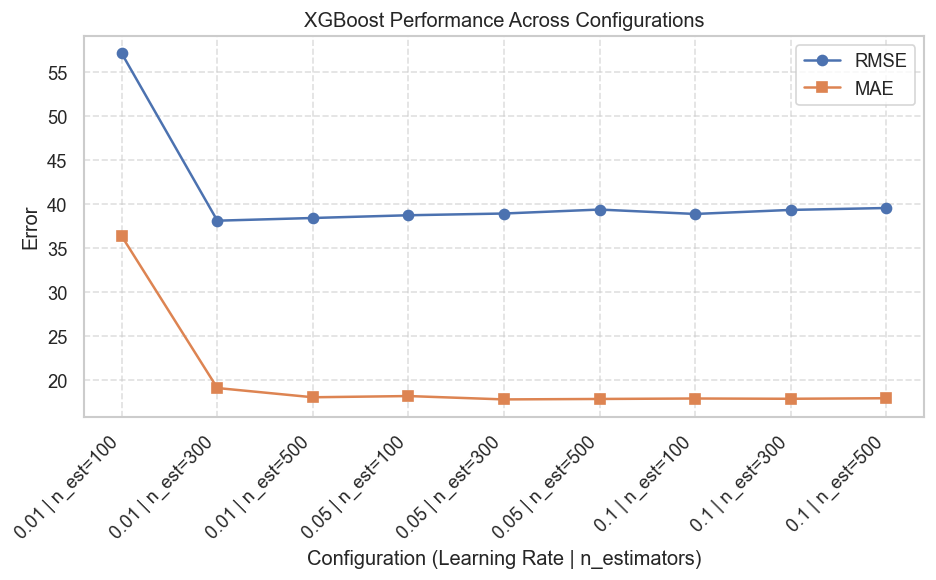

In [ ]:
# XGBoost Performance Visualised
plt.figure(figsize=(8,5))
plt.plot(
    xgb_results['learning_rate'].astype(str) + ' | n_est=' + xgb_results['n_estimators'].astype(str),
    xgb_results['RMSE'],
    marker='o', label='RMSE'
)
plt.plot(
    xgb_results['learning_rate'].astype(str) + ' | n_est=' + xgb_results['n_estimators'].astype(str),
    xgb_results['MAE'],
    marker='s', label='MAE'
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Configuration (Learning Rate | n_estimators)')
plt.ylabel('Error')
plt.title('XGBoost Performance Across Configurations')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(REPORTS / "XGb_config_comparison.png")
plt.show()


In [ ]:
# Neural Network Trials

from sklearn.neural_network import MLPRegressor

mlp_trials = []
for layers in [(50,), (100,), (50, 50)]:
    for lr in [0.001, 0.01]:
        mlp = MLPRegressor(
            hidden_layer_sizes=layers,
            learning_rate_init=lr,
            max_iter=1000,
            random_state=42
        )
        mlp.fit(X_train, y_train)
        preds = mlp.predict(X_test)
        rmse = mean_squared_error(y_test, preds, squared=False)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        mlp_trials.append({
            'Model': 'Neural Network',
            'hidden_layers': layers,
            'learning_rate': lr,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

mlp_results = pd.DataFrame(mlp_trials)
display(mlp_results.sort_values('RMSE'))


c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\duplo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

,Model,hidden_layers,learning_rate,RMSE,MAE,R2
2,Neural Network,"(100,)",0.001,40.755360,20.699386,0.889822
0,Neural Network,"(50,)",0.001,40.905291,21.230967,0.889009
4,Neural Network,"(50, 50)",0.001,41.972427,21.145936,0.883143
1,Neural Network,"(50,)",0.010,42.669006,22.404912,0.879232
3,Neural Network,"(100,)",0.010,43.305003,22.773873,0.875605
5,Neural Network,"(50, 50)",0.010,44.615783,22.764708,0.867960


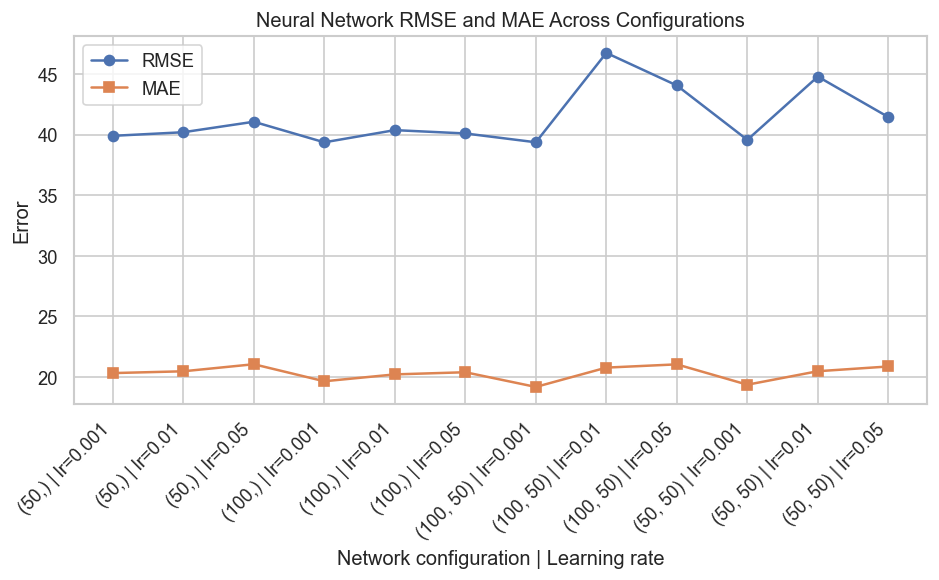

In [ ]:
# Neural Network Performance Visualised
import pandas as pd

# First convert list of dictionaries to DF
mlp_results_df = pd.DataFrame(mlp_results)

# Now plot using the DF
plt.figure(figsize=(8,5))
plt.plot(
    mlp_results_df['hidden_layers'].astype(str) + ' | lr=' + mlp_results_df['learning_rate'].astype(str),
    mlp_results_df['RMSE'],
    marker='o', label='RMSE'
)
plt.plot(
    mlp_results_df['hidden_layers'].astype(str) + ' | lr=' + mlp_results_df['learning_rate'].astype(str),
    mlp_results_df['MAE'],
    marker='s', label='MAE'
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Network configuration | Learning rate')
plt.ylabel('Error')
plt.title('Neural Network RMSE and MAE Across Configurations')
plt.legend()
plt.tight_layout()
plt.savefig(REPORTS / "nn_config_comparison.png")
plt.show()




In [ ]:
# Combine all model results
import pandas as pd

def ensure_df(obj):
    """Convert list of dicts to DataFrame if necessary."""
    if isinstance(obj, list):
        return pd.DataFrame(obj)
    elif isinstance(obj, pd.DataFrame):
        return obj
    else:
        raise TypeError(f"Unexpected type: {type(obj)}")

rf_df = ensure_df(rf_results)
xgb_df = ensure_df(xgb_results)
mlp_df = ensure_df(mlp_results)

combined_results = pd.concat([rf_df, xgb_df, mlp_df], ignore_index=True)

# Highlight the best performers
styled = (
    combined_results.style
    .highlight_min(subset=['RMSE', 'MAE'], color='green')
    .highlight_max(subset=['R2'], color='green')
    .format({'RMSE': '{:.3f}', 'MAE': '{:.3f}', 'R2': '{:.3f}'})
)

display(styled)

combined_results.to_csv(REPORTS / "model_trials_comparison.csv", index=False)


,Model,n_estimators,max_depth,RMSE,MAE,R2,learning_rate,hidden_layers
0,Random Forest,100.000000,10.000000,38.625,18.223,0.901,nan,nan
1,Random Forest,100.000000,20.000000,38.592,17.565,0.901,nan,nan
2,Random Forest,100.000000,nan,38.686,17.549,0.901,nan,nan
3,Random Forest,200.000000,10.000000,38.944,18.269,0.899,nan,nan
4,Random Forest,200.000000,20.000000,38.844,17.526,0.900,nan,nan
5,Random Forest,200.000000,nan,38.805,17.491,0.900,nan,nan
6,Random Forest,500.000000,10.000000,39.074,18.284,0.899,nan,nan
7,Random Forest,500.000000,20.000000,38.780,17.502,0.900,nan,nan
8,Random Forest,500.000000,nan,38.814,17.498,0.900,nan,nan
9,XGBoost,100.000000,nan,57.082,36.310,0.784,0.010000,nan


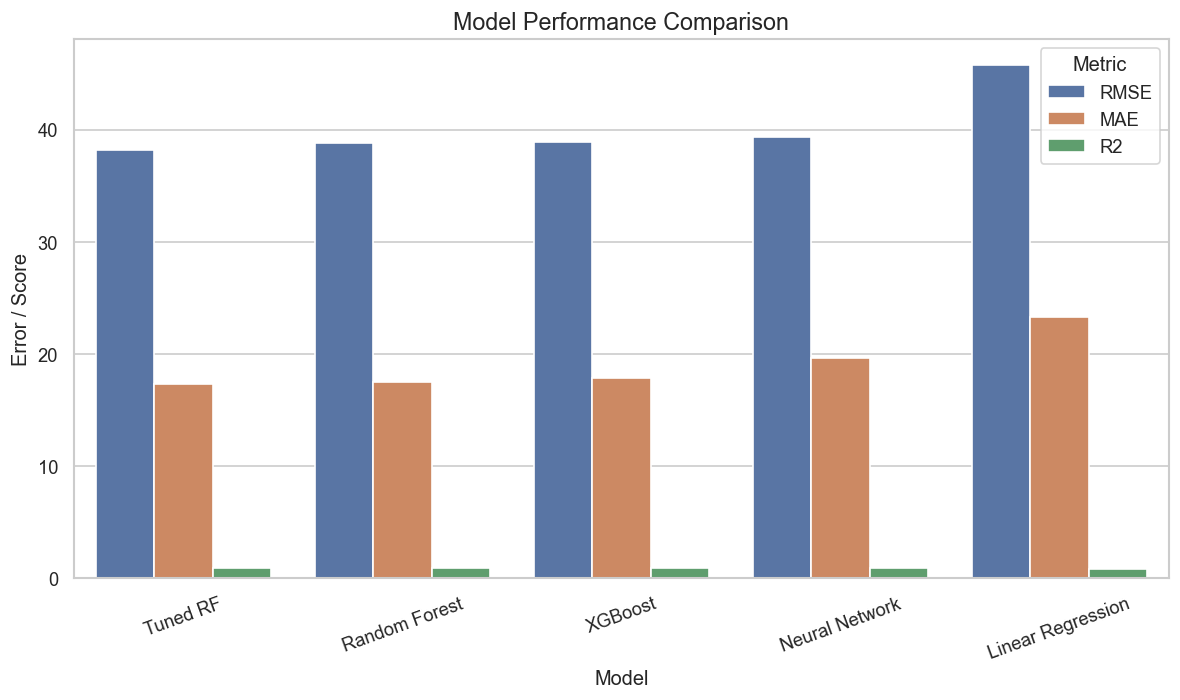

In [ ]:
# Visualisation comparing of model performance
import matplotlib.pyplot as plt
import seaborn as sns

# Check results DF exists
results_plot = results.copy()

plt.figure(figsize=(10, 6))
sns.barplot(data=results_plot.melt(id_vars='Model', 
                                   value_vars=['RMSE', 'MAE', 'R2']),
            x='Model', y='value', hue='variable')

plt.title('Model Performance Comparison', fontsize=14)
plt.ylabel('Error / Score')
plt.xlabel('Model')
plt.xticks(rotation=20)
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig(REPORTS / "model_performance_comparison_chart.png")
plt.show()


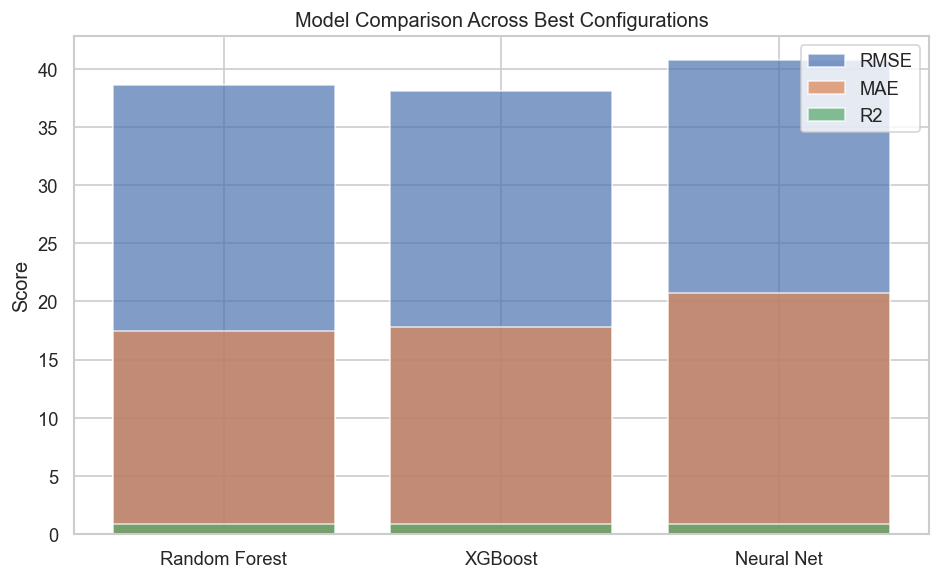

In [ ]:
# Combine the best runs from each model
best_runs = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Neural Net'],
    'RMSE': [
        rf_results['RMSE'].min(),
        xgb_results['RMSE'].min(),
        mlp_results['RMSE'].min()
    ],
    'MAE': [
        rf_results['MAE'].min(),
        xgb_results['MAE'].min(),
        mlp_results['MAE'].min()
    ],
    'R2': [
        rf_results['R2'].max(),
        xgb_results['R2'].max(),
        mlp_results['R2'].max()
    ]
})

# Create a bar plot
best_runs_melt = best_runs.melt(id_vars='Model', value_vars=['RMSE', 'MAE', 'R2'])
plt.figure(figsize=(8,5))
for metric in ['RMSE', 'MAE', 'R2']:
    subset = best_runs_melt[best_runs_melt['variable'] == metric]
    plt.bar(subset['Model'], subset['value'], label=metric, alpha=0.7)
plt.title("Model Comparison Across Best Configurations")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.savefig(REPORTS / "model_comparison_chart.png")
plt.show()

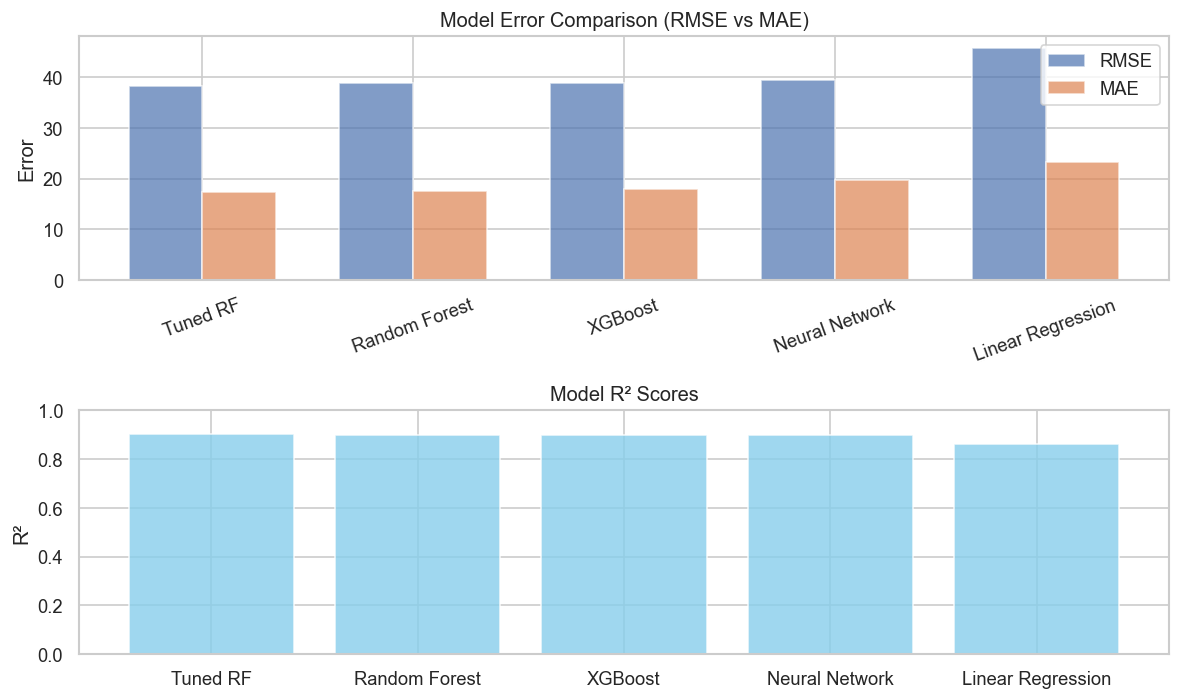

In [ ]:
# Visual comparisons of model performance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Create RMSE and MAE chart
plt.subplot(2, 1, 1)
bar_width = 0.35
x = range(len(results))
plt.bar(x, results['RMSE'], width=bar_width, label='RMSE', alpha=0.7)
plt.bar([i + bar_width for i in x], results['MAE'], width=bar_width, label='MAE', alpha=0.7)
plt.xticks([i + bar_width/2 for i in x], results['Model'], rotation=20)
plt.ylabel('Error')
plt.title('Model Error Comparison (RMSE vs MAE)')
plt.legend()

# Create R² chart
plt.subplot(2, 1, 2)
plt.bar(results['Model'], results['R2'], color='skyblue', alpha=0.8)
plt.ylabel('R²')
plt.title('Model R² Scores')
plt.ylim(0, 1) 

plt.tight_layout()
plt.savefig(REPORTS / "model_performance_comparison.png", bbox_inches='tight', dpi=300)
plt.show()



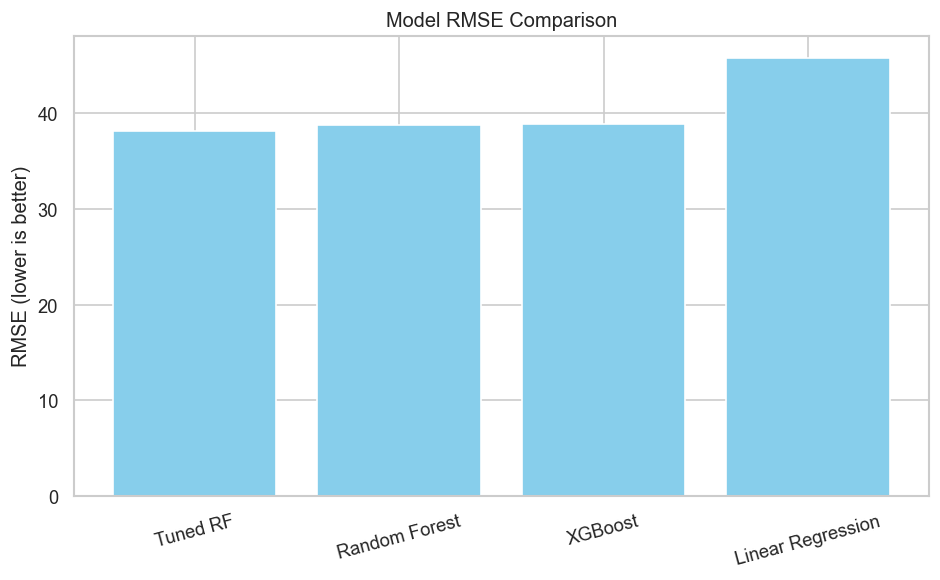

In [ ]:
# Plot model performance
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(results['Model'], results['RMSE'], color='skyblue')
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE (lower is better)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(FIGURES / "model_comparison_rmse.png")
plt.show()


# Statistical Significance Testing
We now perform paired significance tests using paired t-tests and the Wilcoxon Signed-Rank Test to check if the differences between model performances are actually statistically significant.


In [ ]:
from scipy.stats import ttest_rel, wilcoxon
import pandas as pd
import numpy as np

# First we prepare the data by filtering results by model type
rf = combined_results[combined_results["Model"] == "Random Forest"]
xgb = combined_results[combined_results["Model"] == "XGBoost"]
mlp = combined_results[combined_results["Model"] == "Neural Network"]

# Align our sample sizes
min_len = min(len(rf), len(xgb), len(mlp))
rf = rf.head(min_len)
xgb = xgb.head(min_len)
mlp = mlp.head(min_len)

# Conduct paired statistical tests (RMSE & R²)

def model_significance_test(metric, model1, model2, name1, name2):
    """
    Performs both paired t-test and Wilcoxon signed-rank test
    on the chosen performance metric.
    """
    t_stat, t_p = ttest_rel(model1[metric], model2[metric])
    w_stat, w_p = wilcoxon(model1[metric], model2[metric])
    print(f"\n🔹 {name1} vs {name2} — Metric: {metric}")
    print(f"Paired t-test: t={t_stat:.3f}, p={t_p:.4f}")
    print(f"Wilcoxon test: W={w_stat:.3f}, p={w_p:.4f}")
    if t_p < 0.05 or w_p < 0.05:
        print("➡️ Statistically significant difference (p < 0.05)")
    else:
        print("➡️ No significant difference detected")

for metric in ["RMSE", "R2"]:
    model_significance_test(metric, rf, xgb, "Random Forest", "XGBoost")
    model_significance_test(metric, rf, mlp, "Random Forest", "Neural Network")
    model_significance_test(metric, xgb, mlp, "XGBoost", "Neural Network")



🔹 Random Forest vs XGBoost — Metric: RMSE
Paired t-test: t=-1.031, p=0.3326
Wilcoxon test: W=14.000, p=0.3594
➡️ No significant difference detected

🔹 Random Forest vs Neural Network — Metric: RMSE
Paired t-test: t=-2.896, p=0.0200
Wilcoxon test: W=0.000, p=0.0039
➡️ Statistically significant difference (p < 0.05)

🔹 XGBoost vs Neural Network — Metric: RMSE
Paired t-test: t=-0.142, p=0.8902
Wilcoxon test: W=9.000, p=0.1289
➡️ No significant difference detected

🔹 Random Forest vs XGBoost — Metric: R2
Paired t-test: t=1.027, p=0.3345
Wilcoxon test: W=14.000, p=0.3594
➡️ No significant difference detected

🔹 Random Forest vs Neural Network — Metric: R2
Paired t-test: t=2.779, p=0.0239
Wilcoxon test: W=0.000, p=0.0039
➡️ Statistically significant difference (p < 0.05)

🔹 XGBoost vs Neural Network — Metric: R2
Paired t-test: t=-0.001, p=0.9991
Wilcoxon test: W=9.000, p=0.1289
➡️ No significant difference detected


In [ ]:
# Prepare the data for paired model comparisons
from scipy.stats import ttest_rel, wilcoxon
import numpy as np
import pandas as pd

# If not already NumPy Arrays, convert
y_test = np.array(y_test)
err_rf = np.abs(y_test - y_pred_rf_best)
err_xgb = np.abs(y_test - y_pred_xgb)
err_mlp = np.abs(y_test - y_pred_mlp_best)

print(f"Error arrays created: RF={len(err_rf)}, XGB={len(err_xgb)}, MLP={len(err_mlp)} samples")


Error arrays created: RF=5907, XGB=5907, MLP=5907 samples


C:\Users\duplo\AppData\Local\Temp\ipykernel_68360\319419604.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\duplo\AppData\Local\Temp\ipykernel_68360\319419604.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\duplo\AppData\Local\Temp\ipykernel_68360\319419604.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


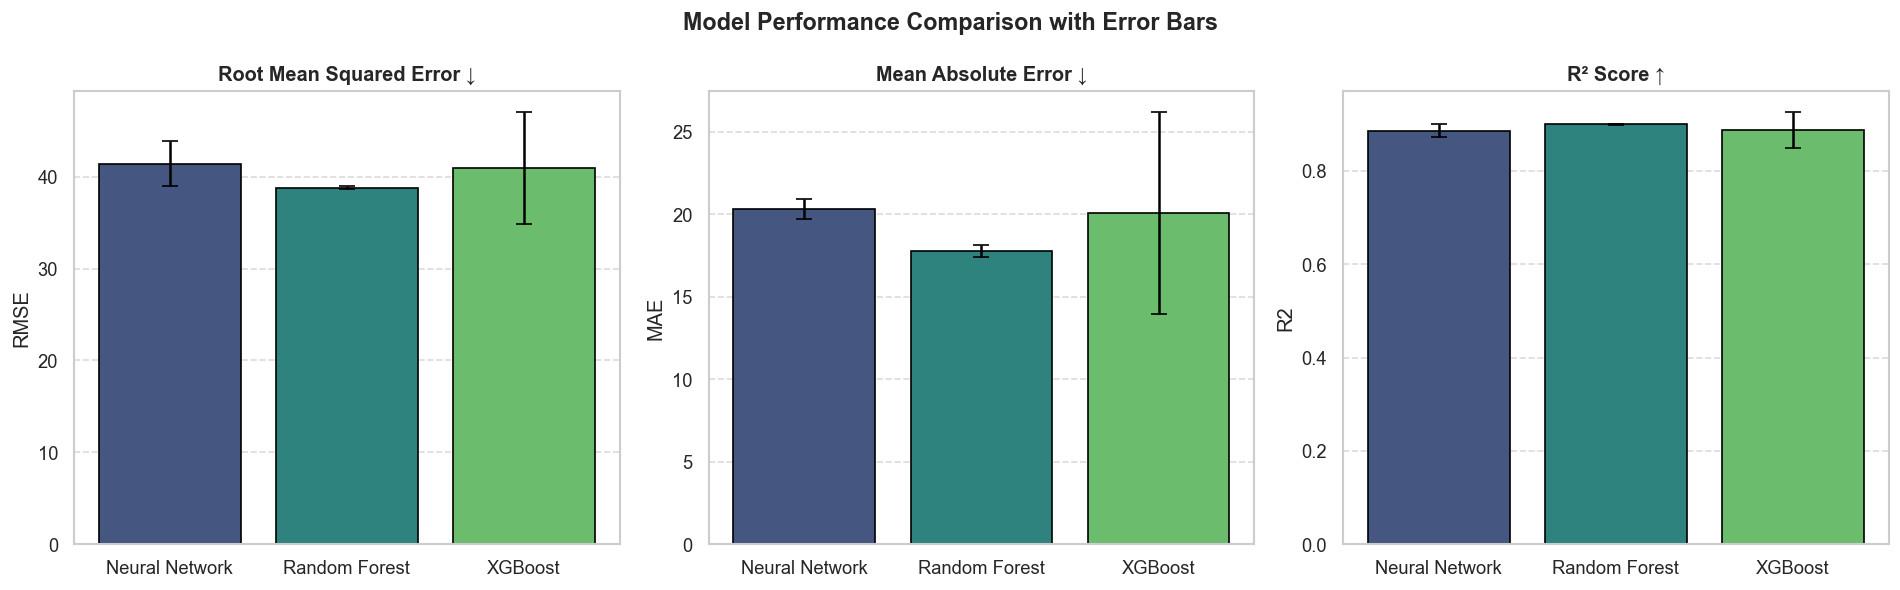

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate the mean and stabdard deviation per model
model_stats = combined_results.groupby("Model").agg({
    "RMSE": ["mean", "std"],
    "MAE": ["mean", "std"],
    "R2": ["mean", "std"]
}).reset_index()

# Flatten multi-index columns
model_stats.columns = ["Model", "RMSE_mean", "RMSE_std", "MAE_mean", "MAE_std", "R2_mean", "R2_std"]

# Setting up Plots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics = [("RMSE", "Root Mean Squared Error ↓"), ("MAE", "Mean Absolute Error ↓"), ("R2", "R² Score ↑")]

for ax, (metric, label) in zip(axes, metrics):
    sns.barplot(
        ax=ax,
        data=model_stats,
        x="Model",
        y=f"{metric}_mean",
        palette="viridis",
        edgecolor="black",
        capsize=0.1
    )

    # Add in error bars
    ax.errorbar(
        x=model_stats["Model"],
        y=model_stats[f"{metric}_mean"],
        yerr=model_stats[f"{metric}_std"],
        fmt="none",
        c="black",
        capsize=5
    )

    ax.set_title(label, fontsize=12, fontweight="bold")
    ax.set_ylabel(metric)
    ax.set_xlabel("")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.suptitle("Model Performance Comparison with Error Bars", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES / "model_rmse_errorbars.png", dpi=300, bbox_inches='tight')
plt.show()




In [91]:
best_per_model = (
    combined_results.loc[combined_results.groupby('Model')['R2'].idxmax(), :]
    .sort_values('R2', ascending=False)
)

print(best_per_model)


             Model  n_estimators  max_depth       RMSE        MAE        R2  \
10         XGBoost         300.0        NaN  38.082303  19.064975  0.903800   
1    Random Forest         100.0       20.0  38.592465  17.565317  0.901206   
21  Neural Network           NaN        NaN  39.363695  19.658450  0.897218   

    learning_rate hidden_layers  
10          0.010           NaN  
1             NaN           NaN  
21          0.001        (100,)  
